# Pulse Sequence Creation with Interactions: The Rydberg Blockade 

The tutorial on [Pulse Sequence Creation](tutorials/sequence/intro.nblink) introduced the creation of a `Sequence` and the core concepts of Pulser. However, in this tutorial, the atoms were placed far from each other such that the interactions between the atoms were neglected... But the interactions between the atoms is at the core of the computations with neutral atom devices as they enable the exchange of information between the qubits. Associated with this exchange is a crucial physical effect : the **Rydberg blockade**.

Prior to this notebook, you might want to read [Simulation of Sequences](tutorials/simulating.nblink), that provides an introduction to simulation of Sequences. To better understand neutral atom devices and how they serve as quantum computers and simulators, check the pages in [Quantum Computing with Neutral Atoms](review.rst).

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import pulser
import pulser_simulation

## The Rydberg Blockade

We have seen in the introduction to the `Sequence` creation that a $\pi$-pulse (a `Pulse` with an amplitude whose integral is equal to $\pi$, and with a detuning and phase set at 0) excites the state of an isolated atom from the ground to the excited state. However, this is no longer the case if the atoms can't be considered isolated anymore: if two atoms are too close to each other, they can't be both in the Rydberg state. This is the **Rydberg Blockade**.

Let's investigate this phenomenon by taking a `Register` of two atoms placed at a minimal distance, and applying a $\pi$-pulse on both of them:

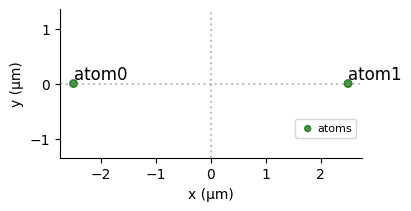

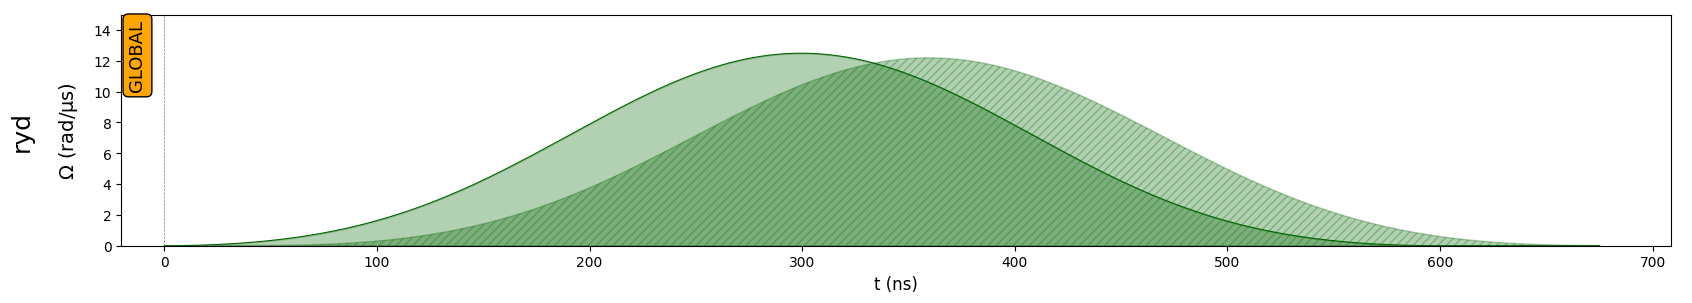

In [52]:
# minimal distance on AnalogDevice is 5µm
reg = pulser.Register.rectangle(1, 2, spacing=5, prefix="atom")
reg.draw()

pi_pulse = pulser.Pulse.ConstantDetuning(
    pulser.BlackmanWaveform(600, np.pi), 0.0, 0.0
)

seq = pulser.Sequence(reg, pulser.AnalogDevice)

seq.declare_channel("ryd", "rydberg_global")

seq.add(pi_pulse, "ryd")

seq.draw()

These atoms are initially in the state $\left|gg\right>$. Let's simulate the executiong of the `Sequence` on these atoms using `pulser-simulation.QutipBackend`:

In [53]:
sim = pulser_simulation.QutipBackend(seq)
res = sim.run()
final_state = res.get_final_state()
print("Final state is: ", final_state)
print(
    "Probability to find the atoms in |rr>: ",
    np.abs(final_state[0][0][0]) ** 2,
)
print(
    "Probability to find the atoms in |rg>: ",
    np.abs(final_state[1][0][0]) ** 2,
)
print(
    "Probability to find the atoms in |gr>: ",
    np.abs(final_state[2][0][0]) ** 2,
)
print(
    "Probability to find the atoms in |gg>: ",
    np.abs(final_state[3][0][0]) ** 2,
)
print(
    "The outcome of 1000 measurements is: ",
    res.sample_final_state(N_samples=1000),
)

Final state is:  Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[1.12277173e-04+0.00063813j]
 [6.54210223e-02+0.56269557j]
 [6.54210223e-02+0.56269557j]
 [5.98487383e-01+0.j        ]]
Probability to find the atoms in |rr>:  4.198097849746515e-07
Probability to find the atoms in |rg>:  0.320906216566327
Probability to find the atoms in |gr>:  0.320906216566327
Probability to find the atoms in |gg>:  0.3581871470575613
The outcome of 1000 measurements is:  Counter({'00': 354, '01': 328, '10': 318})


The probability to find the two atoms in the Rydberg state $\left| rr\right>$ is very small (in the order of magnitude of 1e-7), such that the system is never measured in this state with 1000 measurements. This is the Rydberg Blockade. At the moment, we know this effect arises when the atoms are at short distance of each other, and that it can be neglected when the atoms are far from each other. We investigate the influence of the distance on this effect in the next section.

The final state is a superposition of the states $\left| rg\right>$, $\left| gr\right>$ and $\left| gg\right>$: we can see that having the system in a superposition of states means that we will have different measurement outcomes when measuring multiple times, these frequence of each measurement reflecting the probabilities of measuring each states (probability of measuring each of the 3 states being close to 0.3, we measure each state around 300 times among 1000 measurements). By slightly modifying the Pulse, we can use the Rydberg Blockade effect to produce an anti-ferromagnetic state (AFM).

## The Rydberg Blockade Radius

Let's explore the origin of the **Rydberg Blockade**. The presence of the van der Waals interaction when both atoms are in the Rydberg state, prevents the collective ground state $|gg\rangle$ to couple to $|rr\rangle$, which is shifted out of resonance. 

The Hamiltonian for the two-atom system can be written as:

$$H = \frac{\hbar \Omega(t)}{2} \sigma_1^x + \frac{\hbar \Omega(t)}{2} \sigma_2^x + \frac{C_6}{R^6} n_1n_2 $$

We can neglect the interaction $U = \frac{C_6}{R^6}$ if $U \ll \Omega$, and we shall start taking them into account when $U \approx \Omega$. An indicative value on the distance $R$ below which the Van der Waals interactions have to be taken into account is the **Rydberg radius** $R_b$, it is computed as:
$$U = \Omega_{max} \Leftrightarrow \frac{C_6}{R_b^6} = \Omega_{max}\\
\Leftrightarrow R_b = \left(\frac{C_6}{\Omega_{max}}\right)^{\frac{1}{6}}$$

The Rydberg Radius associated with a given maximum amplitude can be obtained using `Device.rydberg_blockade_radius`. It can also be drawn directly on the `Register`, to have a graphical representation of the interaction between the atoms:

Rydberg Blockade Radius is: 6.409414383495454 µm


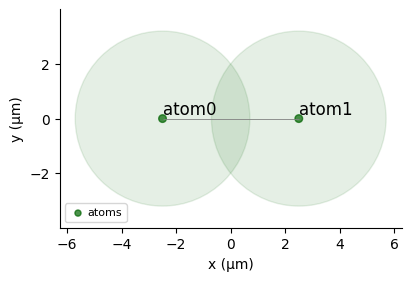

In [54]:
omega_max = np.max(pi_pulse.amplitude.samples)
blockade_radius = pulser.AnalogDevice.rydberg_blockade_radius(omega_max)
print(f"Rydberg Blockade Radius is: {blockade_radius} µm")
reg.draw(blockade_radius=blockade_radius, draw_half_radius=True)

We shall explore this blockade by changing the interatomic distance $R$. We repeat the previous experiment with different interatomic distance $R$, and measure the probability to find the atoms in the excited state $R$ along time. We do this by using the method [`CoherentResults.expect`](https://pulser.readthedocs.io/en/stable/apidoc/simulation.html#pulser_simulation.simresults.CoherentResults.expect), that returns the expectation value of a given operator at each sampled time. We use the projector on the $\left| rr\right>$ state to compute this probability.

In [61]:
data = []
distances = [5, 6, 7, 8, 9, 10, 12]

r = [1, 0]  # |r>
rr = np.kron(r, r)  # |rr>
occup = [np.outer(rr, np.conj(rr))]  # |rr><rr|

for i, R in enumerate(distances):
    # Atom Register and Device
    reg = pulser.Register.rectangle(1, 2, spacing=R, prefix="atom")

    # Pulse Sequence
    seq = pulser.Sequence(reg, pulser.DigitalAnalogDevice)
    seq.declare_channel("ryd", "rydberg_global")
    seq.add(pi_pulse, "ryd")
    sim = pulser_simulation.QutipBackend(seq)

    res = sim.run()  # Returns a SimulationResults instance
    data.append(
        res.expect(occup)[0]
    )  # Get expectation value for the occupation operator
print("...Simulation Complete!")

...Simulation Complete!


We plot the results

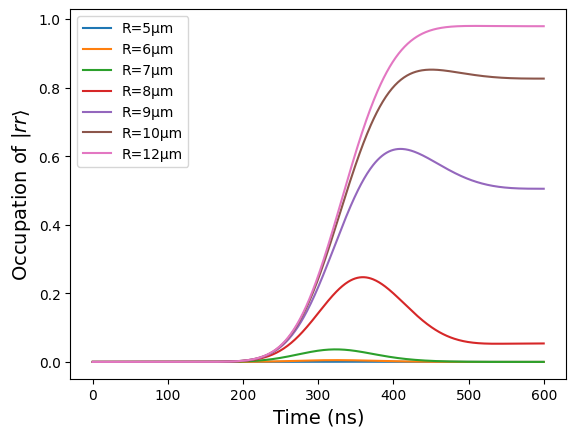

In [63]:
for i, R in enumerate(distances):
    plt.plot(data[i], label=f"R={R}µm")
    plt.xlabel("Time (ns)", fontsize=14)
    plt.ylabel(r"Occupation of $|rr\rangle$", fontsize=14)
    plt.legend()

Notice how the occupation of $|rr\rangle$ is suppressed for decreasing $R$, and that the state is never occupied for $R<R_b$. We can also see that the interaction can be neglected for high $R$ ($R>12 \mu m$ here shows the approximation was correct in the introduction tutorial).

We have looked at the effect of a $\pi$-pulse on a system of atoms in their ground state $\left| gg\right>$, and seen that if the atoms are too close, the Van der Waals interactions between the atoms prevent them from reaching both the excited state $\left| rr\right>$. In fact, if we had applied this $\pi$-pulse on a system where one of the atom had been first excited to the Rydberg state (i.e. the state of system would have been $\left| rg\right>$ or $\left| gr\right>$), the second atom would be prevented `atom1` from being excited to the same state if a $\pi$-pulse was applied on it locally: one atom in the Rydberg state **blockades the excitation of** the second atom to the Rydberg state. We further explore this in the tutorial on local addressability.

This conditional excitation of one atom depending on the state of another closely resembles that of a controlled gate in a quantum circuit. In fact, for neutral atom devices, the **Rydberg blockade mechanism is the key behind entanglement generation between atoms**. It can be used to tailor $CZ$ and multi-controlled Z gate in quantum circuits.